### How the recommendation  system works for a single user

#### The dataset structure
| User query  | Context     | user_id |
| ----------- | ----------- | --------|
| query1      | 0/1/2       |   1     |
| query2      | 0/1/2       |   2     |

Here the query is simply the user query, context can be of three types: Cause of disease/allergy(0), medication/treatment of disease/allergy(1), symptom of disease/allergy(2). Since a mdeical query can belong to any one of the contexts. 

#### How the recommendation takes place
1. Take user's input query ```q1```
2. Convert the query into vector  using tf-idf vectorisation technique
3. Try to predict the context of query using text classification methods(random forest, gradient boost) or Bert classification
4. Now suggest user the next best query belonging to the same context using text matching algorithms(cosine similarity, neural net)

In above method, we can try the steps 2,3 with both simple and advanced methods. Thus we can follow the two approaches.

In [2]:
#importing the libraries
import numpy as np
import pandas as pd

#For Data preprocessing
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()
from nltk.stem import WordNetLemmatizer
ls= WordNetLemmatizer()

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

import torch
import torch.nn as nn
device = torch.device("cuda")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pg21p\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
#Loading the dataset
df=pd.read_csv('allery-V1.csv')
df.head()

,query,disease,context
0,What is allergic rhinitis ?,allergic rhintis,0.0
1,What are the signs and symptoms of allergic rh...,allergic rhintis,2.0
2,What are the complications of allergic rhinitis ?,allergic rhintis,2.0
3,What are the nasal symptoms of allergic rhinit...,allergic rhintis,2.0
4,"What are the ear, eye and throat symptoms of a...",allergic rhintis,2.0


In [4]:
#checking the total count of contexts
df['context'].value_counts()

1.0    48
0.0    43
2.0    21
Name: context, dtype: int64

In [5]:
#Taking the disease "allergic rhintis" and considering it's all queries refer to user 1 and storing in a new dataset
df_new=df[df.disease=='allergic rhintis']
df_new.shape

(112, 3)

In [6]:
#Applying basic pre-processing on the user queries
sentences=df_new['query']
corpus=[]
for i in range(0, len(sentences)):
    review = re.sub('[^a-zA-Z]', ' ', sentences[i]) #keeping only alphabets and removing all other characters 
    review = review.lower() #converting to lowercase
    review = review.split()
    
    review = [ls.lemmatize(word) for word in review if not word in stopwords.words('english')] #performing lemmatisation
    review = ' '.join(review)
    corpus.append(review) #appending to the array corpus

In [7]:
#converting to dataframe
corpus=pd.DataFrame(corpus)

In [8]:
#taking context column from loaded dataset
corpus['context']=df_new['context']

In [9]:
#final dataset obtained after preprocessing
corpus.head()

,0,context
0,allergic rhinitis,0.0
1,sign symptom allergic rhinitis,2.0
2,complication allergic rhinitis,2.0
3,nasal symptom allergic rhinitis,2.0
4,ear eye throat symptom allergic rhinitis,2.0


In [10]:
#renaming column'0' to 'query'
corpus.columns=['query','context']

In [11]:
corpus.head()

,query,context
0,allergic rhinitis,0.0
1,sign symptom allergic rhinitis,2.0
2,complication allergic rhinitis,2.0
3,nasal symptom allergic rhinitis,2.0
4,ear eye throat symptom allergic rhinitis,2.0


# Approach -1

In [12]:
#vectorising the queries
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(max_features = 100) #max length was not more than 100, thus setting 100 features
X = cv.fit_transform(corpus['query']).toarray()

In [13]:
#usinf tf-idf vectorisation
from sklearn.feature_extraction.text import TfidfTransformer
tf_transformer = TfidfTransformer()
X = tf_transformer.fit_transform(X).toarray()

In [14]:
#splitting the dataset
X_train, X_val, y_train, y_val = train_test_split(X, corpus['context'], test_size=0.1)

In [15]:
#Applying random forest to classify the queries context
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train, y_train)


RandomForestClassifier(max_depth=2, random_state=0)

In [16]:
y_pred=clf.predict(X_val)

In [17]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

C:\Users\pg21p\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pg21p\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pg21p\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

         0.0       0.43      0.75      0.55         4
         1.0       0.60      0.75      0.67         4
         2.0       0.00      0.00      0.00         4

    accuracy                           0.50        12
   macro avg       0.34      0.50      0.40        12
weighted avg       0.34      0.50      0.40        12



From the next code cell,we are following the steps:
1. Taking a test query and vectorising it using tf-idf
2. Adding extra 0 columns to make it equal to the train dataset shape for prediction
3. Once we get the "test_context", which is the context value for test query predicted using random forest, we take all the queries from the dataset which match the value of "test_context".
4. Try cosine similarity to find next best query for the test query.

In [18]:
#Taking a test query
test_query = "I have allergic rhintis. what should i do"

In [19]:
#converting query to vector
test_query_arr=cv.fit_transform([test_query]).toarray()

In [20]:
test_query_tfidf = tf_transformer.fit_transform(test_query_arr).toarray()

In [21]:
#Applying padding, i.e. adding extra '0' columns to match the shape of train dataset
columns=[[0]]
for i in range(0,94):
    test_query_tfidf = np.append(test_query_tfidf, columns, axis=1)

In [22]:
#Predicting the context of test query
test_context=clf.predict(test_query_tfidf)

In [23]:
print('the query belongs to context',test_context)

the query belongs to context [1.]


So the context is predicted '1', which means this belongs to a medication type query. Also if we look at our original query which was "I have allergic rhintis. what should i do", we can observe that next best query recommendation can be of any medication like "medication/treatment of allergic rhintis". This tells that our model was able to predict right context for this query.

In [24]:
#Storing all queries in an array which have context==test_context
query_similarto_test=[]
for i in range(0,len(corpus)):
    if corpus['context'][i]==test_context:
        query_similarto_test.append(corpus['query'][i])

In [ ]:
#Function to take up every query from "query_similarto_test" array and finding it's cosine similarity with the test query, 
# the query for which we get the maximum cosine similarity, we will suggest that query to user.
# Compute Cosine Similarity

from sklearn.metrics.pairwise import cosine_similarity
similarity=-1
max_similarity=-1
index=-1
next_best_query=" "

for query in query_similarto_test:
    
    similarity=cosine_similarity(test_query,corpus['query'][i])
    if(similarity>max_sim):
        max_sim=similarity
        next_best_query=query


In [ ]:
print(next_best_query)

# Approach -2

In [25]:
#Importing the libraries
import transformers
from transformers import AutoModel, BertTokenizerFast

In [26]:
# split train dataset into train, validation and test sets
from sklearn.model_selection import train_test_split
train_text, temp_text, train_labels, temp_labels = train_test_split(df_new['query'], df_new['context'], 
                                                                    random_state=2018, 
                                                                    test_size=0.2, 
                                                                    stratify=df_new['context'])


val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels, 
                                                                random_state=2018, 
                                                                test_size=0.2, 
                                                                stratify=temp_labels)

In [27]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-uncased')

# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<AxesSubplot:>

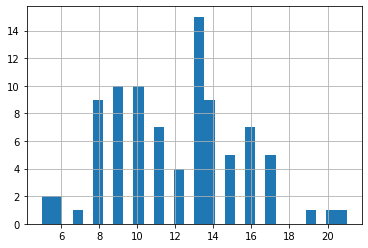

In [28]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)

In [29]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = 13, #setting to 13, since this is the one with highest queries
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = 13,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = 13,
    pad_to_max_length=True,
    truncation=True
)

C:\Users\pg21p\Anaconda3\envs\tensorflow\lib\site-packages\transformers\tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [30]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [31]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [33]:

# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [35]:
class BERT_Arch(nn.Module):

    def __init__(self, bert):
        super(BERT_Arch, self).__init__()

        self.bert = bert 
      
      # dropout layer
        self.dropout = nn.Dropout(0.1)
      
      # relu activation function
        self.relu =  nn.ReLU()

      # dense layer 1
        self.fc1 = nn.Linear(768,512)
      
      # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512,2)

      #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):
        #pass the inputs to the model  
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
      
        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

      # output layer
        x = self.fc2(x)
      
      # apply softmax activation
        x = self.softmax(x)

        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert)

# push the model to GPU
model = model.to(device)